In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [22]:
from toolbox import utils

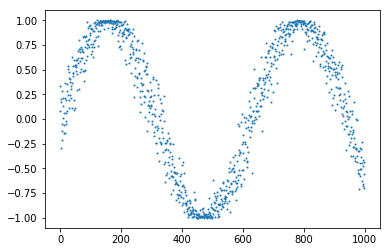

In [21]:
T=1000
time = tf.range(0,T,dtype=tf.float32)
x = tf.sin(0.01*time+tf.random.normal((T,),0,0.2))
plt.scatter(time,x,s=1)

In [20]:
tau = 4
features = tf.Variable(tf.zeros((T-tau,tau)))

for i in range(tau):
    features[:, i].assign(x[i: T-tau+i])
labels = tf.reshape(x[tau:],(-1,1))

print('Features: ',features.shape)
print('Labels: ',labels.shape)

Features:  (996, 4)
Labels:  (996, 1)


In [49]:
batch_size = 50
data_iter = utils.load_array((features,labels),batch_size)

In [50]:
def get_net():
    net = tf.keras.models.Sequential([tf.keras.layers.Dense(10,activation='relu',input_shape=(4,)),
                                     tf.keras.layers.Dense(1)])
    
    return net

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)

    return tf.keras.losses.MSE(y_true=y, y_pred=y_)



In [53]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 21
model=get_net()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.MeanSquaredError()

    # Training loop - using batches of 32
    for x, y in data_iter:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy.update_state(y, model(x, training=True))

        # End epoch
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())
    
    
    if epoch % 4 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))


Epoch 000: Loss: 0.213, Accuracy: 19.267%
Epoch 004: Loss: 0.027, Accuracy: 2.677%
Epoch 008: Loss: 0.025, Accuracy: 2.500%
Epoch 012: Loss: 0.024, Accuracy: 2.407%
Epoch 016: Loss: 0.024, Accuracy: 2.375%
Epoch 020: Loss: 0.024, Accuracy: 2.356%


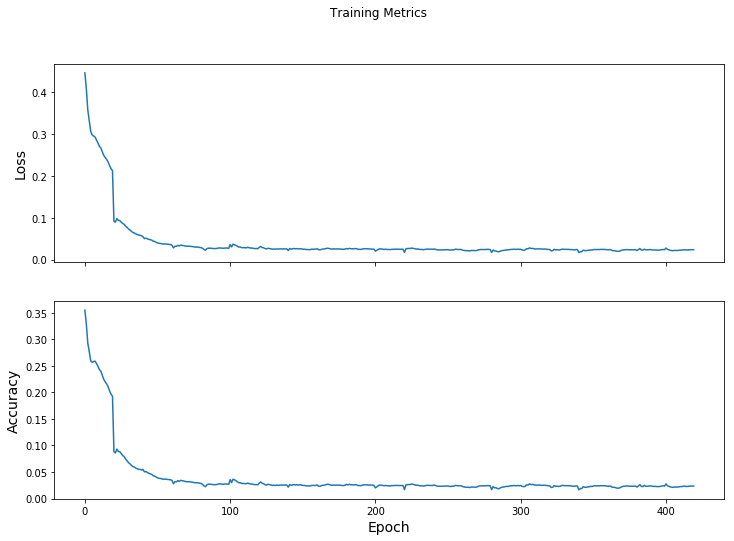

In [54]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()
